In [1]:
%cd ../

/home/users/dmoreno2016/VisionTransformers


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [3]:
all_bands = {
    'u': 0, 
    'g': 1, 
    'r': 2, 
    'i': 3, 
    'z': 4, 
    'Y': 5,
}

dict_columns = {
  'snid': 'SNID',
  'mjd': 'MJD',
  'flux': 'FLUXCAL',
  'flux_err': 'FLUXCALERR',
  'photflag': 'PHOTFLAG',
  'band': 'BAND', 
  'label': 'label',
}

config = {
  'norm_name': 'minmax_by_obj',
  'use_err': False
  }

In [4]:
band_name = dict_columns['band']

df = pd.read_parquet('data/lightcurves/elasticc_1/raw/lc_Cepheid.parquet')
df_md = pd.read_parquet('data/lightcurves/elasticc_1/raw/features_Cepheid.parquet')

grouped = df.groupby('SNID')
first_detection_mjd = grouped.apply(lambda x: x[x['PHOTFLAG'].isin([4096, 6144])]['MJD'].min())
last_detection_mjd = grouped.apply(lambda x: x[x['PHOTFLAG'].isin([4096, 6144])]['MJD'].max())
df['first_detection_mjd'] = df['SNID'].map(first_detection_mjd)
df['last_detection_mjd'] = df['SNID'].map(last_detection_mjd)
df = df[(df['MJD'] >= df['first_detection_mjd'] - 30) & 
        (df['MJD'] <= df['last_detection_mjd'])]
df = df.drop(columns=['first_detection_mjd', 'last_detection_mjd'])
df = df[df['PHOTFLAG'] != 1024]
df[band_name] = df[band_name].replace(all_bands)
df

/tmp/ipykernel_838720/2197119603.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  first_detection_mjd = grouped.apply(lambda x: x[x['PHOTFLAG'].isin([4096, 6144])]['MJD'].min())


In [9]:
def min_max_normalize_lc(group, dict_columns):
    for col in [dict_columns['flux'], dict_columns['flux_err'], dict_columns['mjd']]:
        group[col] = (group[col] - group[col].min()) / (group[col].max() - group[col].min())
    return group

def get_normalization(df, norm_name, dict_columns):
    if norm_name == 'minmax_by_obj':
        return df.groupby([dict_columns['snid']]).apply(min_max_normalize_lc, dict_columns=dict_columns).reset_index(drop=True)
    else:
        raise 'The selected normalization has not been implemented...'

df = get_normalization(df, config['norm_name'], dict_columns)

/tmp/ipykernel_3561561/4291668076.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby([dict_columns['snid']]).apply(min_max_normalize_lc, dict_columns=dict_columns).reset_index(drop=True)


In [10]:
fig_params = {
    #'figsize': [3.84, 3.84],
    'figsize': [2.24, 2.24],
    'fmt': '-o', #-o
    'markersize': 3, # 2.5,
    'linewidth': 1.5, # 1.2,
    'colors': {
      0: '#00FF7F',  # Cercano al verde
      1: '#7FFF00',  # Cercano al verde
      2: '#FF007F',  # Cercano al rojo
      3: '#FF7F00',  # Cercano al rojo
      4: '#007FFF',  # Cercano al azul
      5: '#7F00FF',   # Cercano al azul
    },
    'alpha': 0.5,
    'ylim': [-0.05, 1.05],
}

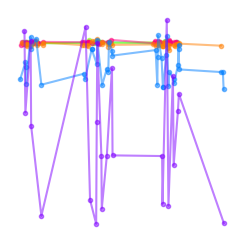

In [184]:
for i, obj_id in enumerate(df[dict_columns['snid']].unique()):
    obj_df = df[df[dict_columns['snid']] == obj_id]

    # Generar la imagen
    fig = plt.figure(figsize=(fig_params['figsize']))
    ax = fig.add_subplot(1, 1, 1)
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

    for j in range(len(all_bands)):
        band_data = obj_df[obj_df[dict_columns['band']] == j]

        if band_data.empty:
            ax.add_patch(patches.Rectangle((0, 0), 1, 1, color='white', transform=ax.transAxes))
        else:
            ax.errorbar(band_data[dict_columns['mjd']], 
                        band_data[dict_columns['flux']], 
                        yerr=band_data[dict_columns['flux_err']] if config['use_err'] else None,
                        color=fig_params['colors'][j],
                        fmt=fig_params['fmt'], 
                        alpha=fig_params['alpha'], 
                        markersize=fig_params['markersize'], 
                        linewidth=fig_params['linewidth'])

        ax.set_ylim(fig_params['ylim'])
        ax.axis('off')

    plt.show()

    break

In [185]:
all_bands

{'u': 0, 'g': 1, 'r': 2, 'i': 3, 'z': 4, 'Y': 5}

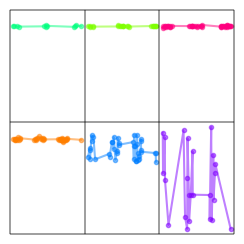

In [186]:
fig, axs = plt.subplots(2, 3, figsize=(2.24, 2.24))  # Dos filas y tres columnas
for band_key, j in all_bands.items():
    row, col = divmod(j, 3)
    band_data = obj_df[obj_df[dict_columns['band']] == j]

    if band_data.empty:
        axs[row, col].add_patch(patches.Rectangle((0, 0), 1, 1, color='white', transform=axs[row, col].transAxes))
    else:
        axs[row, col].errorbar(band_data[dict_columns['mjd']], 
                               band_data[dict_columns['flux']], 
                               yerr=band_data[dict_columns['flux_err']] if config['use_err'] else None,
                               color=fig_params['colors'][j],
                               fmt=fig_params['fmt'], 
                               alpha=fig_params['alpha'], 
                               markersize=fig_params['markersize'], 
                               linewidth=fig_params['linewidth'])

    axs[row, col].set_ylim(fig_params['ylim'])
    axs[row, col].axis('off')

plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)

# Agregar rectángulos para las columnas
for col in range(3):
    rect = patches.Rectangle((col/3, 0), 1/3, 1, linewidth=0.3, edgecolor='black', facecolor='none', transform=fig.transFigure)
    fig.add_artist(rect)

# Agregar rectángulos para las filas
for row in range(2):
    rect = patches.Rectangle((0, row/2), 1, 0.5, linewidth=0.3, edgecolor='black', facecolor='none', transform=fig.transFigure)
    fig.add_artist(rect)

plt.show()

### ASTROMER: Alcock (Single Band)

In [198]:
dict_columns = {
    'snid': 'lcid',
    'mjd': 'mjd',
    'flux': 'flux',
    'flux_err': 'flux_err',
    # photflag': 'detected',
    # band': 'passband',
    'label': 'label'
}


chunk_0 = pd.read_pickle('data/lightcurves/astromer/alcock/fold_0/alcock_20/train/Cep_0/chunk_0.pkl')
chunk_0 = chunk_0.explode('lc_data')
chunk_0[['mjd', 'flux', 'flux_err']] = pd.DataFrame(chunk_0['lc_data'].tolist(), 
                                                    index=chunk_0.index)

# I removed the negative error magnitudes because it doesn't make sense
chunk_0 = chunk_0[chunk_0['flux_err'] >= 0]     
chunk_0 = get_normalization(chunk_0, config['norm_name'], dict_columns)
chunk_0

/tmp/ipykernel_1408354/4291668076.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby([dict_columns['snid']]).apply(min_max_normalize_lc, dict_columns=dict_columns).reset_index(drop=True)


,lcid,lc_data,label,mjd,flux,flux_err
0,b'1.3565.47',"[48824.645, -8.224, 0.008]",0,0.000000,0.641619,0.055556
1,b'1.3565.47',"[48885.605, -8.359, 0.004]",0,0.022438,0.381503,0.011111
2,b'1.3565.47',"[48888.723, -8.359, 0.006]",0,0.023585,0.381503,0.033333
3,b'1.3565.47',"[48896.758, -8.084, 0.007]",0,0.026542,0.911369,0.044444
4,b'1.3565.47',"[48908.445, -8.187, 0.004]",0,0.030844,0.712909,0.011111
...,...,...,...,...,...,...
9734,b'82.8408.27',"[51514.684, -8.05, 0.004]",0,0.987881,0.732719,0.022472
9735,b'82.8408.27',"[51526.586, -8.098, 0.003]",0,0.992408,0.622121,0.011236
9736,b'82.8408.27',"[51531.64, -8.004, 0.006]",0,0.994331,0.838710,0.044944
9737,b'82.8408.27',"[51541.574, -8.19, 0.003]",0,0.998110,0.410139,0.011236


In [211]:
fig_params = {
    #'figsize': [3.84, 3.84],
    'figsize': [2.24, 2.24],
    'fmt': '-o', #-o
    'markersize': 2, # 2.5,
    'linewidth': 0.5, # 1.2,
    'colors': {
      0: '#00FF7F',  # Cercano al verde
      1: '#7FFF00',  # Cercano al verde
      2: '#FF007F',  # Cercano al rojo
      3: '#FF7F00',  # Cercano al rojo
      4: '#007FFF',  # Cercano al azul
      5: '#7F00FF',   # Cercano al azul
    },
    'alpha': 0.5,
    'ylim': [-0.05, 1.05],
}

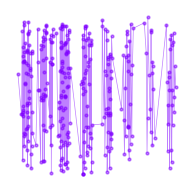

In [212]:
for i, obj_id in enumerate(chunk_0[dict_columns['snid']].unique()):
    obj_df = chunk_0[chunk_0[dict_columns['snid']] == obj_id]

    plt.figure(figsize=fig_params['figsize'])
    plt.errorbar(obj_df[dict_columns['mjd']], 
                obj_df[dict_columns['flux']],
                yerr=obj_df[dict_columns['flux_err']] if config['use_err'] else None,
                color=list(fig_params['colors'].values())[-1], 
                fmt=fig_params['fmt'], 
                alpha=fig_params['alpha'], 
                markersize=fig_params['markersize'],
                linewidth=fig_params['linewidth'])
    plt.axis('off')
    plt.ylim(fig_params['ylim'])

    plt.show()
    break

### ASTROMER: Alcock (Multi-Band)

In [11]:
import glob

dict_columns = {
    'snid': 'lcid',
    'mjd': 'mjd',
    'flux': 'mag',
    'flux_err': 'err',
    # photflag': 'detected',
    'band': 'band',
    'label': 'label'
}

df_alcock = []

for i, path in enumerate(glob.glob('data/lightcurves/alcock_multiband/raw/B/*')):
    lcid = path.split('/')[-1].split('.dat')[0]
    df_B = pd.read_csv(path)
    df_B['lcid'] = lcid
    df_B['band'] = 0
    df_alcock.append(df_B)

    df_R = pd.read_csv(f'data/lightcurves/alcock_multiband/raw/R/{lcid}.dat')
    df_R['lcid'] = lcid
    df_R['band'] = 1
    df_alcock.append(df_R)

    if i == 10:
        break

df_alcock = pd.concat(df_alcock)
df_alcock = df_alcock[df_alcock['err'] >= 0]     
df_alcock = get_normalization(df_alcock, config['norm_name'], dict_columns)
df_alcock

/tmp/ipykernel_3561561/4291668076.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby([dict_columns['snid']]).apply(min_max_normalize_lc, dict_columns=dict_columns).reset_index(drop=True)


,mjd,mag,err,lcid,band
0,0.000000,0.912168,0.941860,11.8623.826,0
1,0.000355,0.773570,0.546512,11.8623.826,0
2,0.001075,0.881547,0.872093,11.8623.826,0
3,0.001449,0.759065,0.395349,11.8623.826,0
4,0.003278,0.741338,0.534884,11.8623.826,0
...,...,...,...,...,...
14728,0.998938,0.131054,0.031250,9.4637.24,1
14729,0.998971,0.116239,0.020833,9.4637.24,1
14730,0.999337,0.119088,0.010417,9.4637.24,1
14731,0.999649,0.114530,0.010417,9.4637.24,1


In [12]:
all_bands = {
    'B': 0, 
    'R': 1, 
}

fig_params = {
    #'figsize': [3.84, 3.84],
    'figsize': [2.56, 2.56],
    'fmt': '-o', #-o
    'markersize': 2., # 2.5,
    'linewidth': 1., # 1.2,
    'colors': {
      0: '#FF007F',  # Cercano al rojo
      1: '#FF7F00',  # Cercano al rojo
      2: '#00FF7F',  # Cercano al verde
      3: '#7FFF00',  # Cercano al verde
      4: '#007FFF',  # Cercano al azul
      5: '#7F00FF',   # Cercano al azul
    },
    'alpha': 0.5,
    'ylim': [-0.05, 1.05],
}

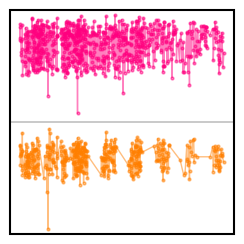

In [13]:
for i, obj_id in enumerate(df_alcock[dict_columns['snid']].unique()):
    obj_df = df_alcock[df_alcock[dict_columns['snid']] == obj_id]

    fig, axs = plt.subplots(2, 1, figsize=(2.24, 2.24))  # Dos filas y tres columnas
    for band_key, j in all_bands.items():
        #row, col = divmod(j, 2)
        row = j
        band_data = obj_df[obj_df[dict_columns['band']] == j]

        if band_data.empty:
            axs[row].add_patch(patches.Rectangle((0, 0), 1, 1, color='white', transform=axs[row].transAxes))
        else:
            axs[row].errorbar(band_data[dict_columns['mjd']], 
                              band_data[dict_columns['flux']], 
                              yerr=band_data[dict_columns['flux_err']] if config['use_err'] else None,
                              color=fig_params['colors'][j],
                              fmt=fig_params['fmt'], 
                              alpha=fig_params['alpha'], 
                              markersize=fig_params['markersize'], 
                              linewidth=fig_params['linewidth'])

        axs[row].set_ylim(fig_params['ylim'])
        axs[row].axis('off')

    plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)

    # Cuadrado grande (borde exterior)
    rect = patches.Rectangle((0, 0), 1, 1, linewidth=1.5, edgecolor='black', facecolor='none', transform=fig.transFigure)
    fig.add_artist(rect)

    # Línea entre las filas
    rect = patches.Rectangle((0, 0.5), 1, 0, linewidth=0.3, edgecolor='black', facecolor='none', transform=fig.transFigure)
    fig.add_artist(rect)

    plt.show()

    break

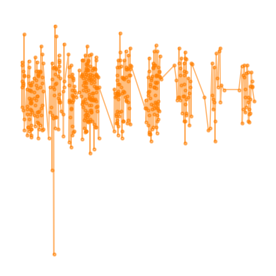

In [14]:
for i, obj_id in enumerate(df_alcock[dict_columns['snid']].unique()):
    obj_df = df_alcock[df_alcock[dict_columns['snid']] == obj_id]

    # Generar la imagen
    fig = plt.figure(figsize=(fig_params['figsize']))
    ax = fig.add_subplot(1, 1, 1)
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

    for j in range(len(all_bands)):
        if j == 1:
            band_data = obj_df[obj_df[dict_columns['band']] == j]

            if band_data.empty:
                ax.add_patch(patches.Rectangle((0, 0), 1, 1, color='white', transform=ax.transAxes))
            else:
                ax.errorbar(band_data[dict_columns['mjd']], 
                            band_data[dict_columns['flux']], 
                            yerr=band_data[dict_columns['flux_err']] if config['use_err'] else None,
                            color=fig_params['colors'][j],
                            fmt=fig_params['fmt'], 
                            alpha=fig_params['alpha'], 
                            markersize=fig_params['markersize'], 
                            linewidth=fig_params['linewidth'])

            ax.set_ylim(fig_params['ylim'])
            ax.axis('off')

    plt.show()

    break